Name and ID

Note: I kept getting a lot of `Numpy` memory errors. So I have optimised for memory by deleting the unnecessary variables at regular intervals.

## Importing Required Packages:

In [1]:
import apmodule as ap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display,display_html
from itertools import chain,cycle
plt.style.use('seaborn')
%matplotlib inline

## Required Functions:

In [2]:
def group_portfolio_returns(data, signal):
    """
    Generates grouped Portfolio Returns based on signal intensity
    
    :param data: dataset with two indices: id and date, and two columns: signal and returns
    :param signal: column name of the signal column
    :param N: number of bins for pd.qcut()
    :return: Portfolio Returns Dataset
    """
    # Choosing the number of bins
    N = 4
    
    # We apply the pandas.qcut() function using a lambda function
    data['group'] = data.groupby('date')[signal].apply(lambda x: pd.qcut(x,N, labels=False))+1
    
    # We calculate average future return for each stock group
    portfolios = data.groupby(['date','group']).mean()
    
    # We unstack the data so it's easier to read and handle
    return portfolios['fut_ret'].unstack(level=1)

def portfolio_metrics(data):
    """
    Generates a dataset with three metrics i.e., Mean Returns, Volatility and 
    Return to Risk Ratio, calculated groupwise on portfolio price data
    
    :param data: portfolio returns dataset grouped by signal intensity
    :return: dataset with calculated metrics
    """
    # annualized mean return
    mean_return = data.mean()*12
    
    # annualized volatility
    volatility = data.std()*np.sqrt(12)
    
    # annualized Return/Risk Ration, a simplified version of the Sharpe ratio without risk-free fate
    rr_ratio = (data.mean()*12) / data.std()*np.sqrt(12)
    
    # Storing the metrics in a DataFrame
    return pd.DataFrame({'Mean Ret.': mean_return,
                            'Std. Dev.': volatility,
                            'RR Ratio': rr_ratio})

def plot_portfolio(data, title_name, kind='line', ylabel='Portfolio Value', logy=False):
    """
    Generates Portfolio Plot
    
    :param data: portfolio price dataset
    :param title_name: 'Qunatile Portfolio '+'title_name'
    :param kind: the kind of graph eg, line, bar hist
    :param ylabel: specify ylabel
    :param logy: specify True or False
    """
    # Plotting the data
    data.plot(figsize=(11,5),
                 kind=kind,
                 title='Portfolio: '+f'{title_name}',
                 xlabel='Time',
                 ylabel=ylabel,
                 logy=logy) #the last argument specifies log-scale for the Y axis

def plot_heatmap(data, title='', vmin=-0.05, vmax=0.25, cmap="rocket_r"):
    """
    Generates a Heat map of the data
    
    :param data: the data frame to plot
    :param vmin: the lower bound of the heat map scale
    :param vmax: the upper bound of the heat map scale
    :param cmap: colour coding of the heat map
    """
    data1 = data.copy()
    data1.index = data1.index.year
    fig, ax = plt.subplots(figsize=(11,5))
    ax.set(title=title)
    sns.heatmap(data1.T, vmin=vmin, vmax=vmax, xticklabels=13, cmap=cmap, ax=ax)
    
def reg_plot(data, name, ylabel='Portfolio Returns'):
    """
    Generates a Scatter plot with a linear regression model fit
    
    :param data: the data frame to plot, data will be divided into seven segments
    :param name: column name of the column to plot
    :param ylabel: required ylabel, default 'Portfolio Returns'
    """
    fig, ax = plt.subplots(figsize=(11, 5))
    for array in np.array_split(data[[name,'Year']], 7):
        sns.regplot(data = array,
                    x = 'Year',
                    y = name,
                    ax = ax
                    ).set(xlabel='',ylabel=ylabel,title='Scatter Plot with Linear Regression line')   
        
def plot_area_graph(data, ylabel, strategy=''):
    """
    Generates Area Plot
    
    :param data: the data frame to plot
    :param ylabel: ylabel name
    :param strategy: strategy name
    """
    data.plot(figsize=(11,5),
                   kind='area',
                   ylabel=f'{ylabel}'+' %',
                   xlabel='Year',
                   title=f'{strategy}'+' Portfolio Industry Exposure',
                   colormap='tab20',
                   ylim=[0,1],
                   xlim=[data.index.min(), data.index.max()])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
    
def display_side_by_side(*args,titles=cycle([''])):
    """
    Generates side by side HTML plot of pandas dataframes
    
    :param *args: Used to pass a variable number of arguments
    :param titles: the user provided titles for the HTML plot, default ''
    """
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        
        # Setting Alignment
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        
        # Aligning the Title
        html_str+=f'<h2 style="text-align: center;">{title}</h2>' 
        
        # Replacing with the table and setting the display style to inline
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    
    # Displaying the dataframe
    display_html(html_str,raw=True)


## Loading the Data:

In [3]:
# we load the prices and calculate the future returns
prices = pd.read_csv('Prices-1.zip', parse_dates=['date']).set_index(['id', 'date'])
future_returns = np.log(prices['price'].groupby('id').shift(-1) / prices['price']).rename('fut_ret')

# we load the information signal. To make our code more general we are going to rename the information signal
signal_epq = pd.read_csv('EPQ.zip', parse_dates=['date']).set_index(['id', 'date'])
signal_ep12 = pd.read_csv('EP12.zip', parse_dates=['date']).set_index(['id', 'date'])
signal_btm = pd.read_csv('BTM.zip', parse_dates=['date']).set_index(['id', 'date'])

# we merge signal and future returns in the same DataFrame
data_epq = signal_epq.join(future_returns).dropna()
data_ep12 = signal_ep12.join(future_returns).dropna()
data_btm = signal_btm.join(future_returns).dropna()
del signal_ep12, signal_btm
display_side_by_side(data_epq.head(), data_epq.tail(), titles=['EPQ Data Head','EPQ Data Tail'])

EPQ Data Head 
 
 
 
 
 epq 
 fut_ret 
 
 
 id 
 date 
 
 
 
 
 
 
 10001 
 1986-11-28 
 -0.341051 
 0.014889 
 
 
 1986-12-31 
 -0.243300 
 -0.036368 
 
 
 1987-01-30 
 -0.323111 
 -0.076961 
 
 
 1987-02-27 
 0.418786 
 0.036139 
 
 
 1987-03-31 
 0.410650 
 -0.040005 
 
 
 EPQ Data Tail 
 
 
 
 
 epq 
 fut_ret 
 
 
 id 
 date 
 
 
 
 
 
 
 93436 
 2021-07-30 
 0.166994 
 0.068224 
 
 
 2021-08-31 
 0.138092 
 0.052633 
 
 
 2021-09-30 
 0.133930 
 0.362230 
 
 
 2021-10-29 
 0.148780 
 0.027238 
 
 
 2021-11-30 
 0.159068 
 -0.079968

## Quantile Analysis:

### Preliminary Analysis:

Initially, I have tried to create my own functions to test the strength of each signal. Once I find the strongest one, I can use the function in apmodule to calculate performance metrics and plots.

In [4]:
# Creating dictionary with data name to run loop on
name_dict = {
    'epq': data_epq,
    'ep12': data_ep12,
    'btm': data_btm
}

# Creating a dictionary with the grouped returns data callable by signal name
returns_dict = {key: group_portfolio_returns(value, key) for key, value in name_dict.items()}

In [5]:
display_side_by_side(portfolio_metrics(returns_dict['epq']),
                     portfolio_metrics(returns_dict['ep12']),
                     portfolio_metrics(returns_dict['btm']), titles=['Signal: EPQ','Signal: EP12','Signal: BTM'])

,Mean Ret.,Std. Dev.,RR Ratio
group,,,
1,-0.216346,0.291057,-8.919742
2,-0.028028,0.208456,-1.613470
3,0.075083,0.167613,5.375437
4,0.124912,0.187895,7.977583
,Mean Ret.,Std. Dev.,RR Ratio
group,,,
1,-0.193946,0.298896,-7.786479
2,-0.016945,0.210603,-0.965537
3,0.064209,0.164762,4.676508


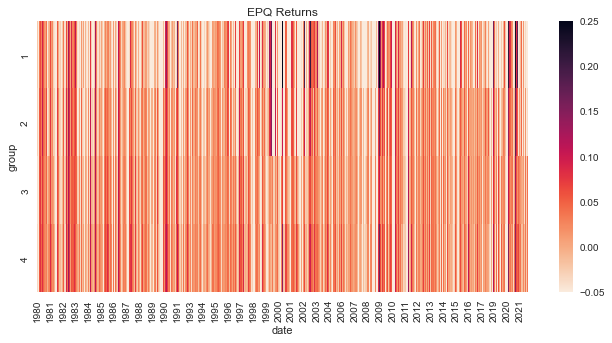

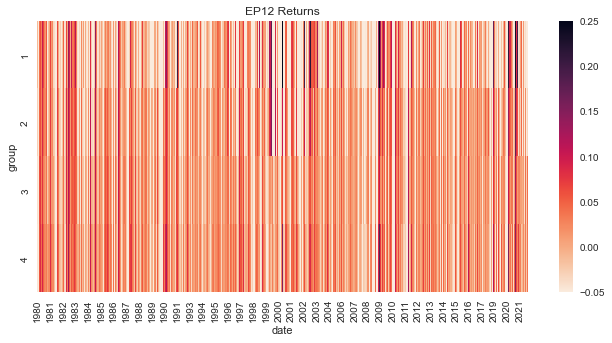

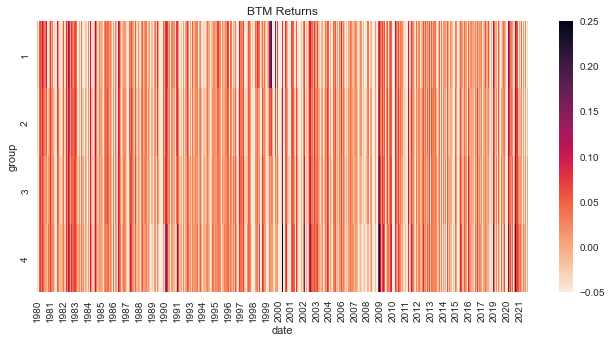

In [6]:
# Plotting the returns as heatmaps
for key, value in returns_dict.items():
    plot_heatmap(value, f'{key.upper()} Returns')

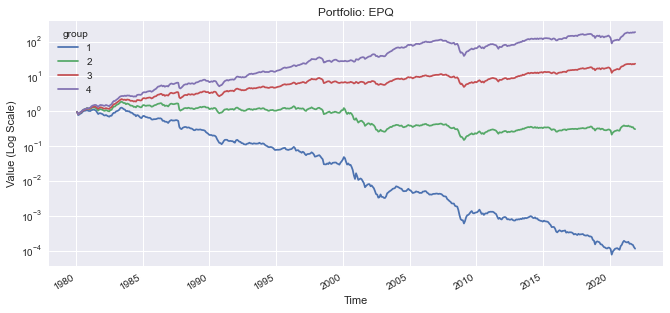

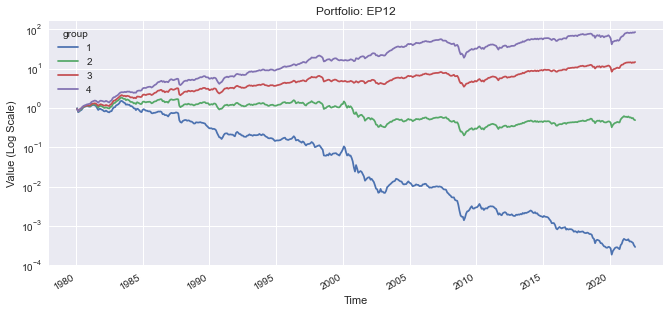

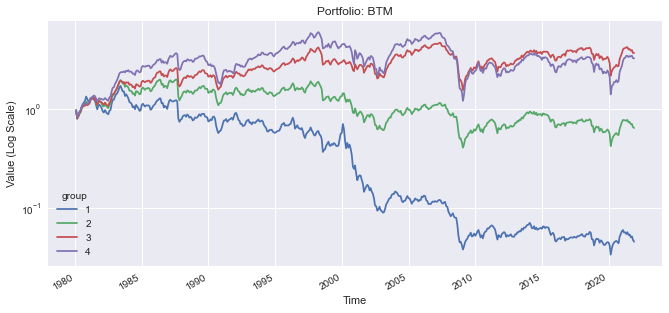

In [7]:
# Creating a dictionary with the portfolio price data callable by signal name
price_dict = {key: value.cumsum().apply(np.exp) for key, value in returns_dict.items()}

# Plotting Portfolio
for key, value in price_dict.items():
    plot_portfolio(value, key.upper(), ylabel='Value (Log Scale)', logy=True)

In [8]:
del data_ep12, data_btm

### Using apmodule functions:

In [9]:
# Performing Quantile analysis with 7 bins
ret_7, perf_7 = ap.quantile_analysis(signal_epq['epq'], prices['price'], n_bins = 7)
perf_7

,1,2,3,4,5,6,7,Benchmark,Active,Neutral
Mean Return,-0.268212,-0.135544,-0.035095,0.039472,0.076229,0.113116,0.131537,-0.011387,0.142924,0.399749
St. Dev.,0.323237,0.252302,0.216970,0.178039,0.166446,0.170364,0.202259,0.204122,0.065292,0.195496
RR Ratio,-0.829768,-0.537229,-0.161748,0.221705,0.457978,0.663963,0.650339,-0.055786,2.188998,2.044790
% Positive,0.387674,0.485089,0.544732,0.594433,0.618290,0.656064,0.646123,0.538767,0.825050,0.801193
Worst Month,-0.412887,-0.393080,-0.385217,-0.350786,-0.333524,-0.317290,-0.383669,-0.360247,-0.087337,-0.291478
Best Month,0.465985,0.237458,0.171860,0.146060,0.125156,0.129643,0.186916,0.173013,0.105290,0.340279
Max DrawDown,-1.645466,-1.189036,-0.882222,-0.714781,-0.694403,-0.745426,-0.953035,-0.926359,-0.197832,-0.482261


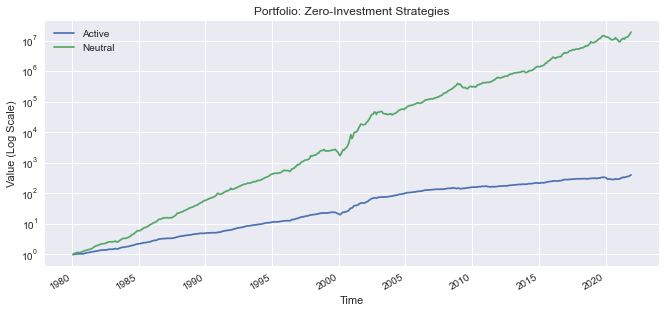

In [10]:
# Plotting Zero Investment Strategies
plot_portfolio(ret_7[['Active','Neutral']].cumsum().apply(np.exp), 
               'Zero-Investment Strategies', ylabel='Value (Log Scale)', logy=True)

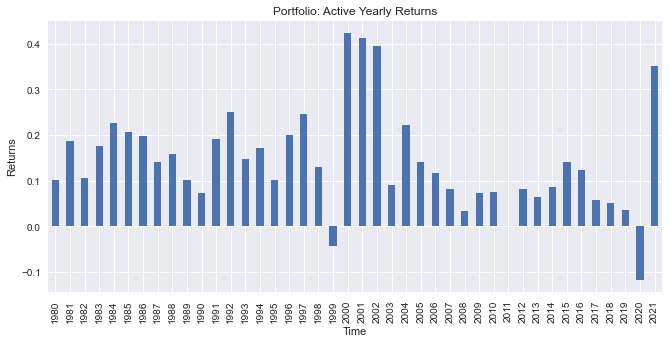

In [11]:
# we extract the year from the index of the DataFrame
ret_7['Year'] = ret_7.index.year

# we take the the mean of the monthly data and multiply by twelve to make calculate yearly return
plot_portfolio(ret_7.groupby('Year')['Active'].mean()*12, 'Active Yearly Returns', 'bar', 'Returns')

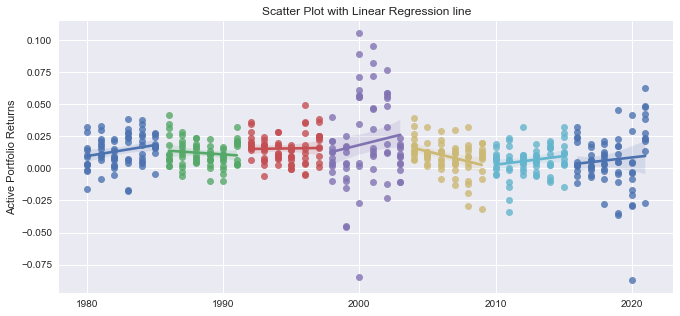

In [12]:
# Plotting scatter with Linear Regression Model Fit
reg_plot(ret_7, 'Active', 'Active Portfolio Returns')

## Backtesting:

In [13]:
# Loading the required data and converting to pandas series
market_cap = pd.read_csv('Market_cap.zip', parse_dates=['date']).set_index(['id', 'date'])

stock_prices = prices.squeeze()
market_cap = market_cap.squeeze()

In [14]:
# converting the signal to pandas series
factor = signal_epq.squeeze()
# backtesting through apmodule function
p_ret, p_turn, p_comp, p_perf = ap.backtesting(factor, stock_prices, market_cap, 
                                               start='2005-01-01', end='2020-12-31', 
                                               t_cost=0.002, N=250)
p_perf

,Portfolio,Benchmark,Active
Mean Return,0.040140,0.063838,-0.023698
St. Dev.,0.230274,0.156919,0.111499
RR Ratio,0.174313,0.406818,-0.212539
% Positive,0.604167,0.651042,0.494792
Worst Month,-0.378713,-0.201336,-0.177377
Best Month,0.187581,0.123162,0.086454
Max DrawDown,-1.002301,-0.694557,-0.331825


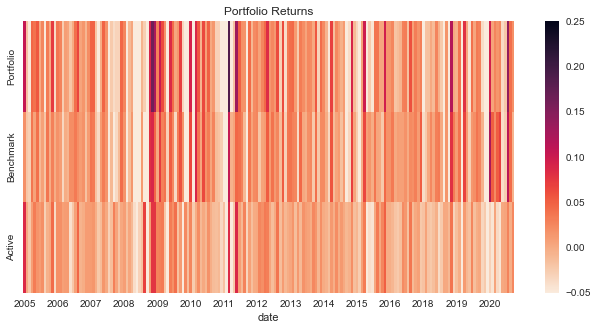

In [15]:
# Plotting returns as heatmap
plot_heatmap(p_ret, 'Portfolio Returns')

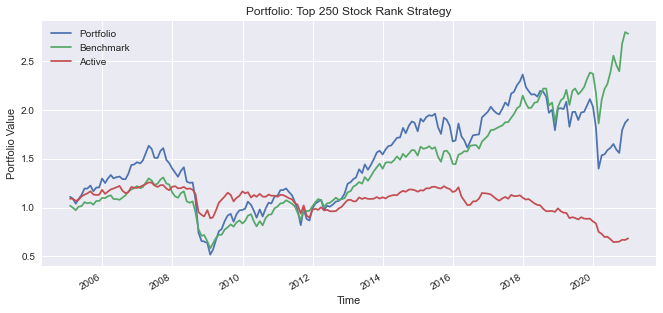

In [16]:
#we derive the portfolio values from the monthly returns then plot it
port_values = p_ret.cumsum().apply(np.exp)
plot_portfolio(port_values, 'Top 250 Stock Rank Strategy')

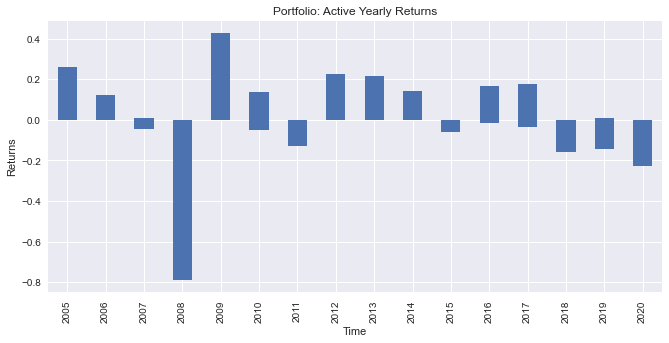

In [17]:
# we extract the year from the index of the DataFrame
p_ret['Year'] = p_ret.index.year

# we take the the mean of the monthly data and multiply by twelve to calculate yearly return and plot
plot_portfolio(p_ret.groupby('Year')['Portfolio'].mean()*12, 'Yearly Returns', 'bar', 'Returns')
plot_portfolio(p_ret.groupby('Year')['Active'].mean()*12, 'Active Yearly Returns', 'bar', 'Returns')

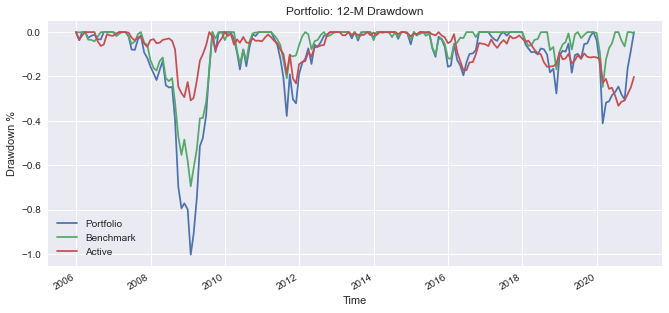

In [18]:
#we take the max portfolio value over the last 12 months
rolling_peak = port_values.rolling(12).max()

#we take the percentage difference between the current value and the rolling peak
drawdown = np.log(port_values/rolling_peak)

# plotting drawdown
plot_portfolio(drawdown, '12-M Drawdown', ylabel='Drawdown %')

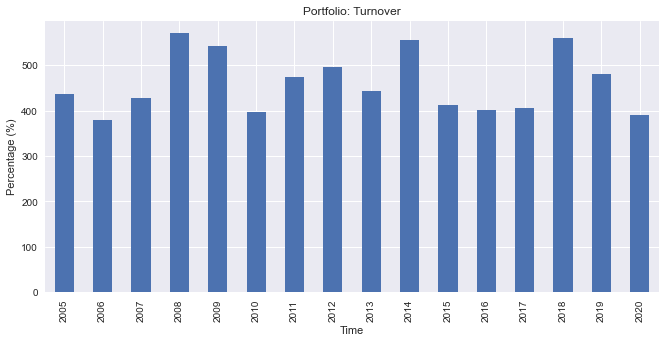

In [19]:
#we generate a column with the years extracted by the index
p_turn['Year'] = p_turn.index.year

#we sum the monthly turnover by year and plot
plot_portfolio(p_turn.groupby('Year')['Turnover'].sum()*100, 'Turnover', ylabel='Percentage (%)', kind='bar')

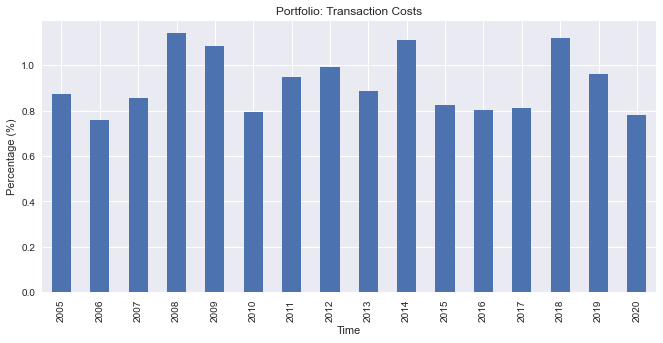

In [20]:
#we sum the monthly transaction cost by year and plot
plot_portfolio(p_turn.groupby('Year')['T-Cost'].sum()*100, 'Transaction Costs', ylabel='Percentage (%)', kind='bar')

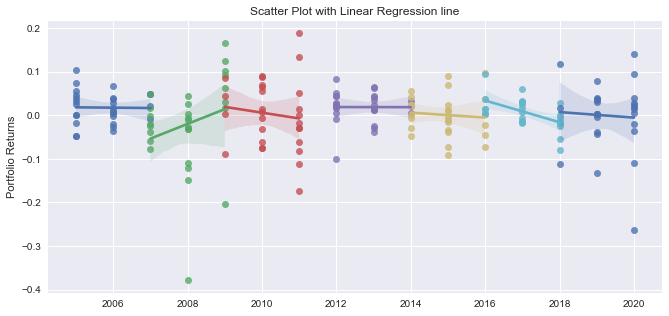

In [21]:
# Plotting scatter with Linear Regression Model Fit
reg_plot(p_ret, 'Portfolio')

#### Industry Exposure

In [22]:
# Loading the names data
names = pd.read_csv('names.zip').set_index('id')

In [23]:
# Joining named data to portfolio composition data
p_comp = p_comp.join(names, how='left')

# Grouping by date and industry then summing to later calculate exposure
port_exposure = p_comp.groupby(['date', 'industry'])['Portfolio'].sum()
port_exposure.head()

date        industry             
2005-01-31  Business Equipment       0.044655
            Chemicals                0.008139
            Consumer Durables        0.008863
            Consumer non Durables    0.020332
            Finance                  0.173620
Name: Portfolio, dtype: float64

In [24]:
#unstacking multi index dataframe
port_exposure = port_exposure.unstack(level=1)

#we extract the year from the index
port_exposure['Year'] = port_exposure.index.year

#we calculate the mean exposure by year (for simplicity we replace the old DataFrame)
port_exposure = port_exposure.groupby('Year').mean()
port_exposure.head()

industry,Business Equipment,Chemicals,Consumer Durables,Consumer non Durables,Finance,Healthcare,Manufacturing,"Oil, Gas, and Coal",Other,Retail,Telecommunications,Utilities
Year,,,,,,,,,,,,
2005,0.037958,0.034546,0.038145,0.032105,0.207638,0.003840,0.095493,0.278241,0.153434,0.045324,0.019547,0.053731
2006,0.029157,0.018597,0.010469,0.024563,0.247289,0.004356,0.051552,0.418217,0.127915,0.030058,0.003953,0.033874
2007,0.020847,0.003718,0.019468,0.028827,0.450469,0.009956,0.041628,0.240857,0.090509,0.036902,0.010685,0.046134
2008,0.052889,0.024707,0.007249,0.054388,0.161445,0.061303,0.093950,0.326439,0.073754,0.061766,0.041030,0.041082
2009,0.037931,0.035373,0.031844,0.064445,0.225478,0.121206,0.062949,0.166644,0.065305,0.096037,0.024467,0.068321


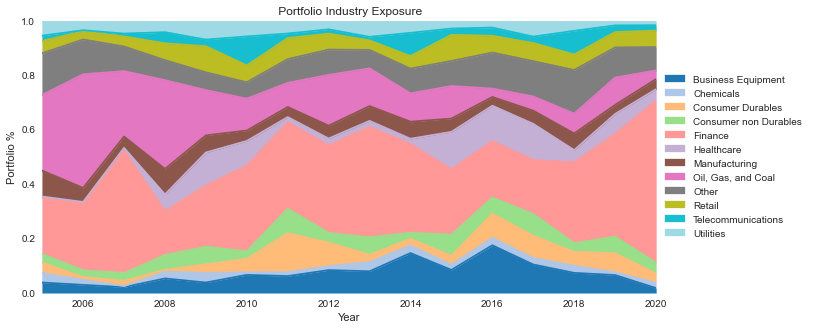

In [25]:
# Plotting area graph for industry exposure
plot_area_graph(port_exposure, 'Portfolio')

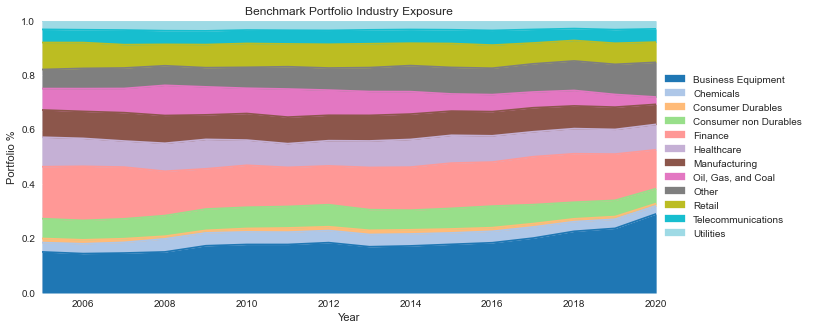

In [26]:
#we sum teh weights of the stocks for each industry and month
bench_exposure = p_comp.groupby(['date', 'industry'])['Benchmark'].sum()

#we put the data of each industry in a different column
bench_exposure = bench_exposure.unstack(level=1)

#we xtract the year from the index
bench_exposure['year'] = bench_exposure.index.year

#we take the mean average exposure within each year and plot
bench_exposure = bench_exposure.groupby('year').mean()

# Plotting area graph for industry exposure
plot_area_graph(bench_exposure, 'Portfolio', 'Benchmark')

In [27]:
del p_turn, p_comp, p_perf, names, port_exposure, bench_exposure

### Combination Strategy

In [28]:
# Loading the beta signal
signal_tvol = pd.read_csv('TVOL.zip', parse_dates=['date']).set_index(['id', 'date'])

#### Linear Models:

First model:
$$\textbf{f(a,x)}=\textbf{a}-\textbf{x}$$

In [29]:
# calculating signal, renaming and sending to frame
signal1 = (signal_epq['epq']-signal_tvol['tvol']).rename('Signal').to_frame()
# performing Quantile Analysis
ret1, perf1 = ap.quantile_analysis(signal1['Signal'], prices['price'], n_bins = 5)
perf1

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,0.037738,0.081512,0.073043,0.046880,-0.005737,0.046671,-0.052409,-0.043475
St. Dev.,0.142423,0.166418,0.185125,0.205069,0.241552,0.180965,0.094550,0.155106
RR Ratio,0.264970,0.489804,0.394562,0.228607,-0.023752,0.257902,-0.554294,-0.280294
% Positive,0.582505,0.636183,0.602386,0.580517,0.540755,0.594433,0.403579,0.471173
Worst Month,-0.220619,-0.293704,-0.347175,-0.359418,-0.411884,-0.326550,-0.147128,-0.231864
Best Month,0.163990,0.163558,0.194263,0.178584,0.248897,0.173859,0.137999,0.223498
Max DrawDown,-0.782927,-0.828158,-0.922942,-0.948637,-0.941451,-0.881991,-0.633787,-0.882885


Secong Model:
$$\textbf{f(a,x)}=\textbf{a}+\textbf{x}$$

In [30]:
signal2 = (signal_epq['epq']+signal_tvol['tvol']).rename('Signal').to_frame()
ret2, perf2 = ap.quantile_analysis(signal2['Signal'], prices['price'], n_bins = 5)
perf2

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.109445,0.048978,0.078719,0.097136,0.118118,0.046671,0.071447,0.227563
St. Dev.,0.264817,0.210921,0.185247,0.167354,0.126847,0.180965,0.093519,0.207063
RR Ratio,-0.413284,0.232213,0.424938,0.580421,0.931185,0.257902,0.763986,1.099004
% Positive,0.467197,0.588469,0.614314,0.640159,0.683897,0.594433,0.594433,0.666004
Worst Month,-0.421646,-0.364111,-0.343298,-0.309838,-0.193897,-0.326550,-0.111386,-0.286914
Best Month,0.286425,0.197464,0.182290,0.156878,0.106456,0.173859,0.132652,0.264006
Max DrawDown,-1.116655,-0.969038,-0.916548,-0.808040,-0.599889,-0.881991,-0.292408,-0.635672


Third Model:
$$\textbf{f(a,x)}=\sum^{n}{(x_{i}+|a_{i}|)}$$

In [31]:
signal3 = (signal_epq['epq']+abs(signal_tvol['tvol'])).rename('Signal').to_frame()
ret3, perf3 = ap.quantile_analysis(signal3['Signal'], prices['price'], n_bins = 5)
perf3

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.026338,0.065399,0.080546,0.081561,0.032302,0.046671,-0.014369,0.058640
St. Dev.,0.214301,0.186586,0.176630,0.158023,0.191524,0.180965,0.060316,0.084654
RR Ratio,-0.122903,0.350504,0.456015,0.516136,0.168656,0.257902,-0.238236,0.692698
% Positive,0.532803,0.602386,0.626243,0.636183,0.590457,0.594433,0.479125,0.592445
Worst Month,-0.369495,-0.342921,-0.329693,-0.303028,-0.295793,-0.326550,-0.081363,-0.135924
Best Month,0.265353,0.186061,0.159294,0.129680,0.184926,0.173859,0.080264,0.086504
Max DrawDown,-1.124578,-0.900272,-0.853202,-0.732661,-0.798902,-0.881991,-0.322281,-0.237594


Fourth Model:
    $$P=P_{1}+P_{2}$$

In [32]:
ret4_1, perf4_1 = ap.quantile_analysis(signal_epq['epq'], prices['price'], n_bins = 5)

ret4_2, perf4_2 = ap.quantile_analysis(-1*signal_tvol['tvol'], prices['price'], n_bins = 5)

real_ret = (ret4_1 + ret4_2)/2

ap.diagnostics(real_ret)

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.066507,0.006112,0.051339,0.060273,0.023161,0.014784,0.008377,0.089668
St. Dev.,0.194459,0.190400,0.181231,0.187336,0.216790,0.191183,0.042334,0.053008
RR Ratio,-0.342012,0.032102,0.283277,0.321737,0.106837,0.077330,0.197877,1.691618
% Positive,0.491054,0.560636,0.618290,0.602386,0.558648,0.564612,0.499006,0.731610
Worst Month,-0.296347,-0.346932,-0.342384,-0.344329,-0.369073,-0.339795,-0.048526,-0.072726
Best Month,0.204980,0.175732,0.161982,0.158733,0.217135,0.170835,0.074705,0.066768
Max DrawDown,-0.995530,-0.889444,-0.852784,-0.840474,-0.955498,-0.906520,-0.137295,-0.109557


In [33]:
del signal1, signal3, ret1, perf1, ret2, perf2, ret3, perf3, ret4_1, perf4_1, ret4_2, perf4_2, real_ret

#### Non Linear Models:

First Model:
$$\textbf{f(a,x)}=\sum^{n}{a_{i}\cdot|x_{i}|}$$

In [34]:
signal4 = (abs(signal_tvol['tvol'])*signal_epq['epq']).rename('Signal').to_frame()
ret4, perf4 = ap.quantile_analysis(signal4['Signal'], prices['price'], n_bins = 5)
perf4

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.098859,0.057151,0.075583,0.094513,0.105115,0.046671,0.058444,0.203974
St. Dev.,0.240453,0.188094,0.177010,0.159906,0.164401,0.180965,0.041795,0.114888
RR Ratio,-0.411135,0.303843,0.426998,0.591052,0.639384,0.257902,1.398357,1.775414
% Positive,0.459245,0.592445,0.616302,0.644135,0.654076,0.594433,0.677932,0.755467
Worst Month,-0.371566,-0.349026,-0.335301,-0.303388,-0.273489,-0.326550,-0.055756,-0.176944
Best Month,0.295047,0.174872,0.153264,0.128009,0.156212,0.173859,0.057898,0.108736
Max DrawDown,-1.243889,-0.921459,-0.834720,-0.725670,-0.687719,-0.881991,-0.099466,-0.432385


Second Model:
$$\textbf{f(a,x)}=\sum^{n}{\frac{a_{i}}{|x_{i}|}}$$

In [35]:
signal5 = (signal_epq['epq']/abs(signal_tvol['tvol'])).rename('Signal').to_frame()
ret5, perf5 = ap.quantile_analysis(signal5['Signal'], prices['price'], n_bins = 5)
perf5

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.126076,0.051241,0.090764,0.110411,0.107195,0.046671,0.060523,0.233270
St. Dev.,0.256883,0.159009,0.159007,0.176389,0.187778,0.180965,0.033350,0.133727
RR Ratio,-0.490790,0.322251,0.570816,0.625949,0.570858,0.257902,1.814785,1.744373
% Positive,0.455268,0.612326,0.648111,0.644135,0.636183,0.594433,0.735586,0.799205
Worst Month,-0.381423,-0.301992,-0.284193,-0.318084,-0.346949,-0.326550,-0.028802,-0.188045
Best Month,0.302783,0.145630,0.136000,0.145501,0.168089,0.173859,0.038544,0.187865
Max DrawDown,-1.282568,-0.697776,-0.735055,-0.821197,-0.883568,-0.881991,-0.091469,-0.457112


Scaled Models:
$$\textbf{f(a,x)}=\sum^{n}{a_{i}\cdot|1+x_{i}|}$$
$$\textbf{f(a,x)}=\sum^{n}{a_{i}\cdot|-1+x_{i}|}$$

In [36]:
signal6 = (signal_epq['epq']*abs(1+signal_tvol['tvol'])).rename('Signal').to_frame()
signal7 = (signal_epq['epq']*abs(-1+signal_tvol['tvol'])).rename('Signal').to_frame()
ret6, perf6 = ap.quantile_analysis(signal6['Signal'], prices['price'], n_bins = 5)
ret7, perf7 = ap.quantile_analysis(signal7['Signal'], prices['price'], n_bins = 5)

display_side_by_side(perf6,titles=['Positive Bias'])
display_side_by_side(perf7,titles=['Negative Bias'])

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.113384,0.034731,0.073800,0.107817,0.130542,0.046671,0.083871,0.243926
St. Dev.,0.253728,0.206346,0.181186,0.161889,0.142092,0.180965,0.071344,0.170214
RR Ratio,-0.446873,0.168314,0.407318,0.665996,0.918713,0.257902,1.175588,1.433060
% Positive,0.451292,0.578529,0.616302,0.664016,0.695825,0.594433,0.638171,0.723658
Worst Month,-0.377737,-0.373884,-0.342108,-0.304640,-0.234419,-0.326550,-0.082845,-0.220319
Best Month,0.291851,0.173953,0.157572,0.154906,0.122954,0.173859,0.092130,0.207334
Max DrawDown,-1.225971,-0.926749,-0.848478,-0.775094,-0.634188,-0.881991,-0.209022,-0.579316


,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.088494,0.074681,0.081569,0.073252,0.092486,0.046671,0.045814,0.180980
St. Dev.,0.216325,0.150786,0.167727,0.186936,0.214635,0.180965,0.054882,0.087421
RR Ratio,-0.409081,0.495277,0.486318,0.391857,0.430896,0.257902,0.834782,2.070203
% Positive,0.447316,0.640159,0.630219,0.610338,0.614314,0.594433,0.652087,0.775348
Worst Month,-0.359439,-0.276508,-0.283224,-0.339284,-0.380910,-0.326550,-0.083044,-0.092582
Best Month,0.252683,0.132526,0.171933,0.152052,0.198845,0.173859,0.087948,0.110307
Max DrawDown,-1.098282,-0.764506,-0.805650,-0.891485,-0.860957,-0.881991,-0.181410,-0.266690


Inverse Models:
$$\textbf{f(a,x)}=\sum^{n}{a_{i}\cdot\Bigg|1+\frac{1}{x_{i}}\Bigg|}$$
$$\textbf{f(a,x)}=\sum^{n}{a_{i}\cdot\Bigg|-1+\frac{1}{x_{i}}\Bigg|}$$

In [37]:
signal8 = (signal_epq['epq']*abs(1+1/signal_tvol['tvol'])).rename('Signal').to_frame()
signal9 = (signal_epq['epq']*abs(-1+1/signal_tvol['tvol'])).rename('Signal').to_frame()
ret8, perf8 = ap.quantile_analysis(signal8['Signal'], prices['price'], n_bins = 5)
ret9, perf9 = ap.quantile_analysis(signal9['Signal'], prices['price'], n_bins = 5)

display_side_by_side(perf8,titles=['Positive Bias'])
display_side_by_side(perf9,titles=['Negative Bias'])

,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.114764,0.036877,0.086888,0.110545,0.113969,0.046671,0.067298,0.228733
St. Dev.,0.255588,0.201764,0.145870,0.160537,0.182462,0.180965,0.036352,0.136143
RR Ratio,-0.449022,0.182774,0.595650,0.688595,0.624616,0.257902,1.851270,1.680097
% Positive,0.451292,0.594433,0.640159,0.664016,0.644135,0.594433,0.747515,0.777336
Worst Month,-0.382007,-0.376256,-0.270325,-0.272095,-0.331923,-0.326550,-0.034874,-0.200626
Best Month,0.287534,0.175165,0.113973,0.140194,0.169932,0.173859,0.048211,0.191408
Max DrawDown,-1.222850,-0.916796,-0.653093,-0.738099,-0.879592,-0.881991,-0.117913,-0.451368


,1,2,3,4,5,Benchmark,Active,Neutral
Mean Return,-0.087814,0.070967,0.059319,0.085311,0.105692,0.046671,0.059021,0.193506
St. Dev.,0.214125,0.151434,0.177425,0.195024,0.193693,0.180965,0.033111,0.091982
RR Ratio,-0.410104,0.468634,0.334332,0.437440,0.545668,0.257902,1.782532,2.103730
% Positive,0.453280,0.634195,0.610338,0.620278,0.626243,0.594433,0.729622,0.781312
Worst Month,-0.358539,-0.252778,-0.300853,-0.362009,-0.358505,-0.326550,-0.031955,-0.095287
Best Month,0.248780,0.134325,0.171634,0.151469,0.165091,0.173859,0.036598,0.117396
Max DrawDown,-1.087545,-0.768922,-0.815536,-0.875128,-0.874632,-0.881991,-0.068784,-0.291727


In [38]:
del signal4, signal5, signal7, ret4, perf4, ret5, perf5, ret6, perf6, ret7, perf7, ret8, perf8, ret9, perf9 

### Backtesting

Linear Additive Model:

In [39]:
p_ret1, p_turn1, p_comp1, p_perf1 = ap.backtesting(signal2.squeeze(), stock_prices, market_cap, 
                                                  start='2005-01-01', end='2020-12-31', 
                                                   t_cost=0.002, N=250)
p_perf1

,Portfolio,Benchmark,Active
Mean Return,0.068328,0.063560,0.004768
St. Dev.,0.115091,0.156942,0.078049
RR Ratio,0.593682,0.404989,0.061087
% Positive,0.614583,0.651042,0.484375
Worst Month,-0.124587,-0.201351,-0.065031
Best Month,0.085754,0.123098,0.083743
Max DrawDown,-0.443312,-0.694722,-0.215730


Inverse Models:

In [40]:
p_ret2, p_turn2, p_comp2, p_perf2 = ap.backtesting(signal8.squeeze(), stock_prices, market_cap, 
                                                   start='2005-01-01', end='2020-12-31', 
                                                   t_cost=0.002, N=250)

p_ret3, p_turn3, p_comp3, p_perf3 = ap.backtesting(signal9.squeeze(), stock_prices, market_cap, 
                                                   start='2005-01-01', end='2020-12-31', 
                                                   t_cost=0.002, N=250)

display_side_by_side(p_perf2, p_perf3, titles=['Postitive Bias','Negative Bias'])

,Portfolio,Benchmark,Active
Mean Return,0.079590,0.063560,0.016031
St. Dev.,0.207615,0.156942,0.085274
RR Ratio,0.383357,0.404989,0.187989
% Positive,0.609375,0.651042,0.588542
Worst Month,-0.283969,-0.201351,-0.090177
Best Month,0.139951,0.123098,0.074184
Max DrawDown,-0.864714,-0.694722,-0.274709
,Portfolio,Benchmark,Active
Mean Return,0.085648,0.063560,0.022088
St. Dev.,0.206287,0.156942,0.087096


Scaled Model:

In [41]:
p_ret4, p_turn4, p_comp4, p_perf4 = ap.backtesting(signal6.squeeze(), stock_prices, market_cap, 
                                               start='2005-01-01', end='2020-12-31', 
                                               t_cost=0.002, N=250)
p_perf4

,Portfolio,Benchmark,Active
Mean Return,0.069768,0.063560,0.006208
St. Dev.,0.129957,0.156942,0.070615
RR Ratio,0.536850,0.404989,0.087910
% Positive,0.619792,0.651042,0.489583
Worst Month,-0.143796,-0.201351,-0.060443
Best Month,0.117957,0.123098,0.076922
Max DrawDown,-0.506103,-0.694722,-0.179184


#### Plotting Performance:

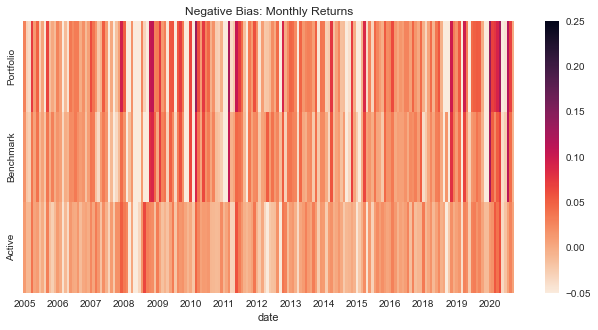

In [42]:
plot_heatmap(p_ret3, 'Negative Bias: Monthly Returns')

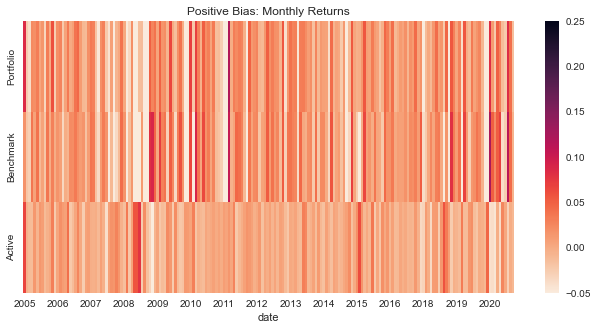

In [43]:
plot_heatmap(p_ret4, 'Positive Bias: Monthly Returns')

In [44]:
p_ret = p_ret['Portfolio'].rename('Value Only').to_frame()
p_ret3 = p_ret3.join(p_ret).dropna()
p_ret4 = p_ret4.join(p_ret).dropna()

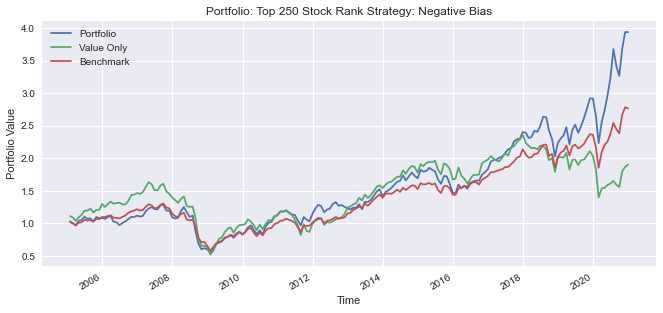

In [45]:
#we derive the portfolio values from the monthly returns then plot it
plot_portfolio(p_ret3[['Portfolio', 'Value Only', 'Benchmark']].cumsum().apply(np.exp), 'Top 250 Stock Rank Strategy: Negative Bias')

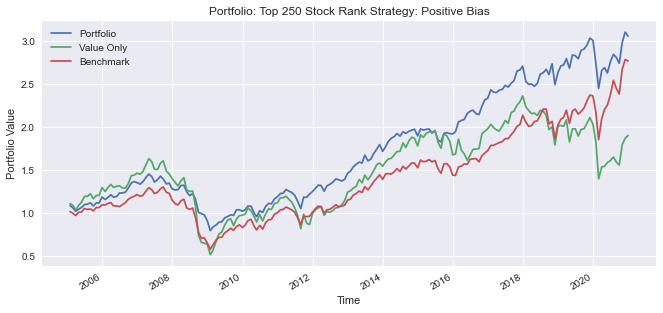

In [46]:
#we derive the portfolio values from the monthly returns then plot it
plot_portfolio(p_ret4[['Portfolio', 'Value Only', 'Benchmark']].cumsum().apply(np.exp), 'Top 250 Stock Rank Strategy: Positive Bias')

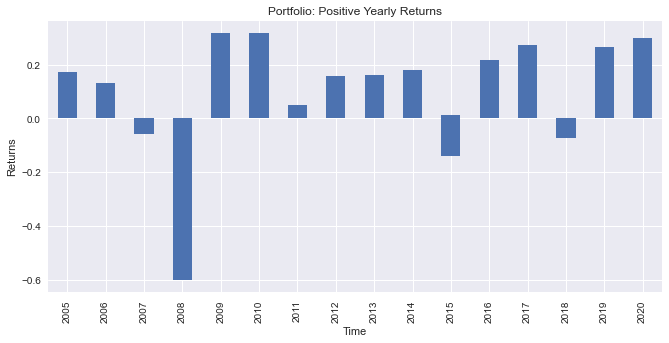

In [47]:
# we extract the year from the index of the DataFrame
p_ret3['Year'] = p_ret3.index.year
p_ret4['Year'] = p_ret4.index.year

# we take the the mean of the monthly data and multiply by twelve to make calculate yearly return
plot_portfolio(p_ret3.groupby('Year')['Portfolio'].mean()*12, 'Negative Yearly Returns', 'bar', 'Returns')
plot_portfolio(p_ret4.groupby('Year')['Portfolio'].mean()*12, 'Positive Yearly Returns', 'bar', 'Returns')

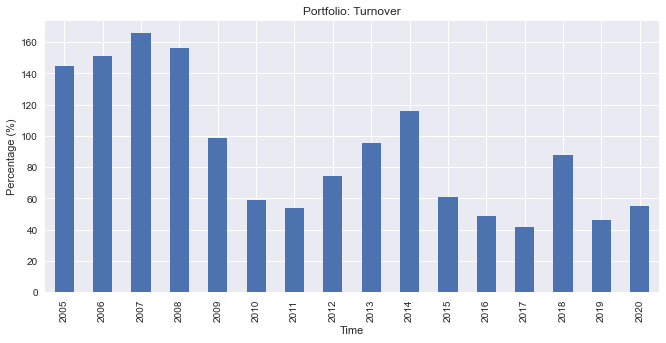

In [48]:
#we generate a column with the years extracted by the index
p_turn3['Year'] = p_turn3.index.year

#we sum the monthly turnover by year and plot
plot_portfolio(p_turn3.groupby('Year')['Turnover'].sum()*100, 'Turnover', ylabel='Percentage (%)', kind='bar')

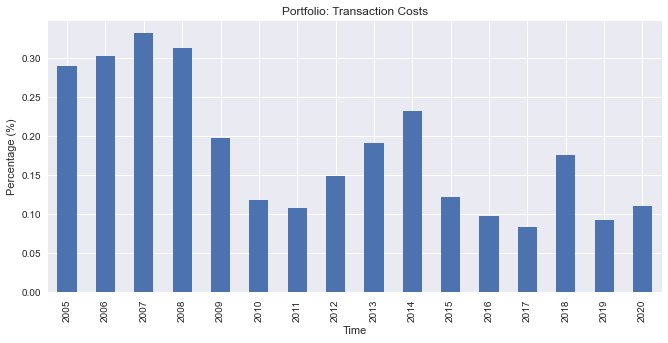

In [49]:
#we sum the monthly transaction cost by year and plot
plot_portfolio(p_turn3.groupby('Year')['T-Cost'].sum()*100, 'Transaction Costs', ylabel='Percentage (%)', kind='bar')

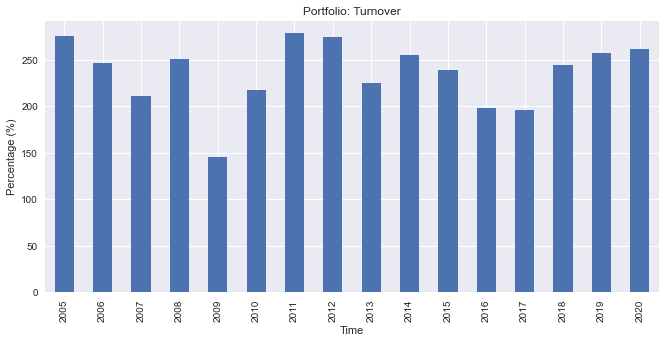

In [50]:
#we generate a column with the years extracted by the index
p_turn4['Year'] = p_turn4.index.year

#we sum the monthly turnover by year and plot
plot_portfolio(p_turn4.groupby('Year')['Turnover'].sum()*100, 'Turnover', ylabel='Percentage (%)', kind='bar')

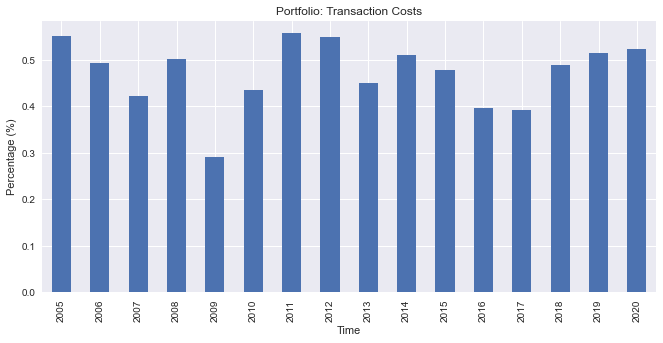

In [51]:
#we sum the monthly transaction cost by year and plot
plot_portfolio(p_turn4.groupby('Year')['T-Cost'].sum()*100, 'Transaction Costs', ylabel='Percentage (%)', kind='bar')

In [52]:
factor = signal9.squeeze()

In [53]:
del signal2, signal6, signal8, signal9, p_ret1, p_turn1, p_comp1, p_perf1, p_ret2, p_turn2, p_comp2, p_perf2

In [54]:
del p_ret3, p_turn3, p_comp3, p_perf3, p_ret4, p_turn4, p_comp4, p_perf4

### Strategy Optimisation

In [ ]:
# creating two data frames:
df1, df2 = pd.DataFrame(), pd.DataFrame()
# looping through the parameters:
for index in [1,3,12]:
    for count in [100,250,1000]:
        p_ret, p_turn, p_comp, p_perf = ap.backtesting(factor, stock_prices, market_cap, 
                                               start='2005-01-01', end='2020-12-31', 
                                               frequency=index, t_cost=0.002, N=count)
        # saving the Information ratio
        df1.loc[f'{index} month(s)', f'{count} shares'] = p_perf.loc['RR Ratio', 'Active']
        # saving the mean portfolio returns
        df2.loc[f'{index} month(s)', f'{count} shares'] = p_perf.loc['Mean Return', 'Portfolio']
    
display_side_by_side(df1, df2, titles=['Information Ratio', 'Mean Return'])